In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
import os
def readImages(dir, pattern):
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), flatten))

vehicles = readImages('./training_images/vehicles', '*.png')
non_vehicles = readImages('./training_images/non-vehicles', '*.png')

Vehicle image count: 8792
Non-vehicle image count: 8968


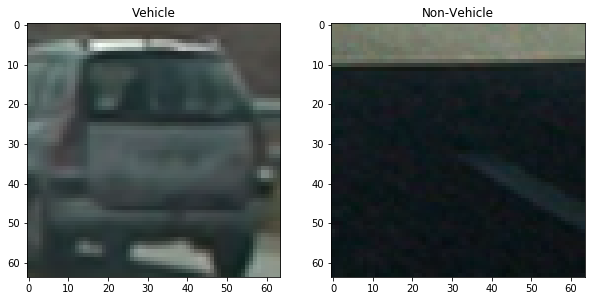

In [3]:
vehicle = vehicles[0]
non_vehicle = non_vehicles[0]

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(vehicle)
axes[0].set_title('Vehicle')
axes[1].imshow(non_vehicle)
axes[1].set_title('Non-Vehicle')

print('Vehicle image count: {}'.format(len(vehicles)))
print('Non-vehicle image count: {}'.format(len(non_vehicles)))

# Step 1: Feature Extraction

**Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.**

I chose the following parameters:

    cspace: 'YCrCb',
    orient: 10,
    pix_per_cell: 8,
    cell_per_block = 2,
    hog_channel = 'ALL',
    size = (16, 16),
    hist_bins = 64,
    hist_range = (0, 256)
    
The main issue I encountered in tuning parameters was false positives. I managed to get rid of most of them through trial and error, but I still don't feel fully confident about the robustness of the pipeline. I ultimately tried to avoid the false positives by increasing the histogram bins and number of orientations. Interestingly, I read in a paper that only 16 buckets was optimal in some pedestrian detection applications of HOG, but I found that 16 histogram bins performed very poorly for my application.


In [4]:
 hog_parameters = {
    'cspace': 'YCrCb',
    'orient': 10,
    'pix_per_cell': 8,
    'cell_per_block': 2,
    'hog_channel': 'ALL',
    'size': (16, 16),
    'hist_bins': 64,
    'hist_range': (0, 256)
 }
     
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        
def extract_features(image):
    cspace = hog_parameters['cspace']
    orient = hog_parameters['orient']
    pix_per_cell = hog_parameters['pix_per_cell']
    cell_per_block = hog_parameters['cell_per_block']
    hog_channel = hog_parameters['hog_channel']
    size = hog_parameters['size']
    hist_bins = hog_parameters['hist_bins']
    hist_range = hog_parameters['hist_range']

    # convert to RGB / make a copy
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))


**Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them)**

I used `StandardScaler` from sklearn's `preprocessing` class to normalize my data. How did I not know about this method before??! I've been doing manual normalization of feature vectors for years.

I also used the `train_test_split` method from the sklearn `model_selection` class to spit the data into 80/20 training and test sets.

The classifier I chose was a support vector machine, trained on both HOG and color features. It achieved 99.3% accuracy on the test images.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

def fitModel(positive, negative, svc, scaler):
    positive_features = list(map(lambda img: extract_features(img), positive))
    negative_features = list(map(lambda img: extract_features(img), negative))
    
    # Stacking and scaling
    X = np.vstack((positive_features, negative_features)).astype(np.float64)    
    X_scaler = scaler.fit(X)
    scaled_X = X_scaler.transform(X)
    
    # Defining objective
    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Fitting
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)


In [6]:
from sklearn.svm import LinearSVC

svc, scaler, fittingTime, accuracy = fitModel(vehicles, non_vehicles, LinearSVC(), StandardScaler())
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

/Users/dfrenk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Fitting time: 15.74 s, Accuracy: 0.9949


/Users/dfrenk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


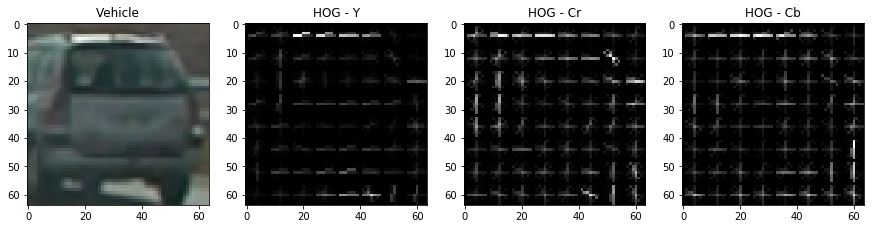

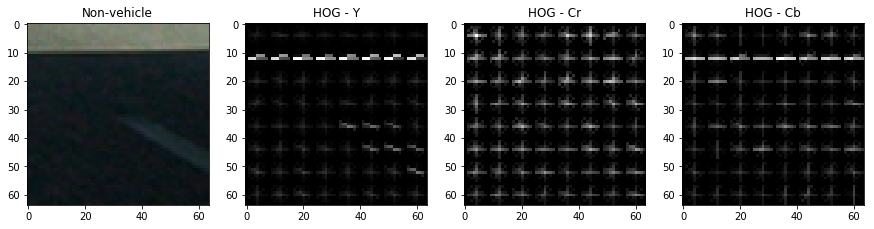

In [7]:
def showHOG(img, title):
    orient = hog_parameters['orient']
    pix_per_cell = hog_parameters['pix_per_cell']
    cell_per_block = hog_parameters['cell_per_block']
    
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, hog_y = get_hog_features(img_cspaced[:,:,0], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

showHOG(vehicle, 'Vehicle')
showHOG(non_vehicle, 'Non-vehicle')

# Step 2: Sliding Windows


**Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?**

I basically just took the code from the lesson and played with the parameters. I saw little improvement by deviating from the sensible defaults of 64 * 64 with a 50% overlap in both x and y directions.

In [8]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

**Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?**

As you can see later in this notebook, I applied HOG sub-sampling and heatmap thresholding to improve performance.

In [9]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))

In [10]:
def findCarWindows(img, clf, scaler, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def drawCars(img, windows):
    output = np.copy(img)
    return draw_boxes(output, windows)

In [11]:
car_on_test = list(map(lambda img: drawCars(img, findCarWindows(img, svc, scaler)), test_images))

/Users/dfrenk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


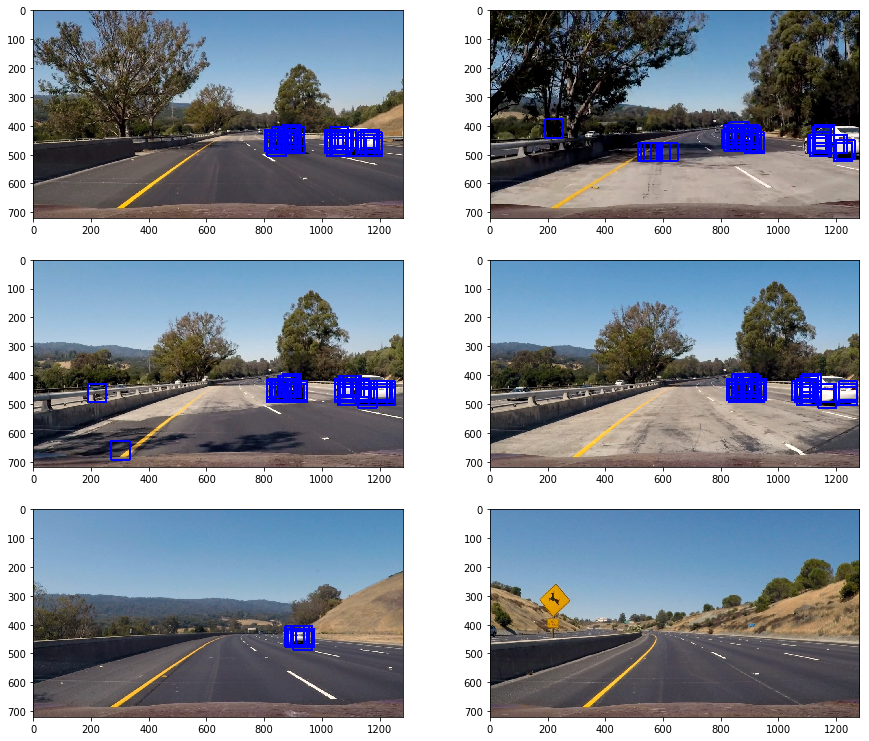

In [12]:
def showImages(images, cols = 2, rows = 3, figsize=(15,13)):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            ax.imshow(image)
            
showImages(car_on_test)

# Step 3: Thresholding, Sub-Sampling, and Final Pipeline

**Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.**

I applied heatmap thresholding. Based on the code in the lesson, I filtered out pixels in each box that did not meet a threshold, then combined neighboring boxes based on min and max values in the x and y directions.

Combining boxes made the classifier a lot more useful for identifying cars, and thresholding helped reduce false positives. 

The performance could still be improved (e.g. I still noticed a single vehicles being classified as multiple, and vice versa) but it was sufficient for reasonable performance on the video (and to be honest, I was just happy to get rid of the false positives, which were driving me crazy!). When I applied HOG subsampling, this problem went away, and in the end I was quite happy with the performance of the enhanced pipeline.



/Users/dfrenk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


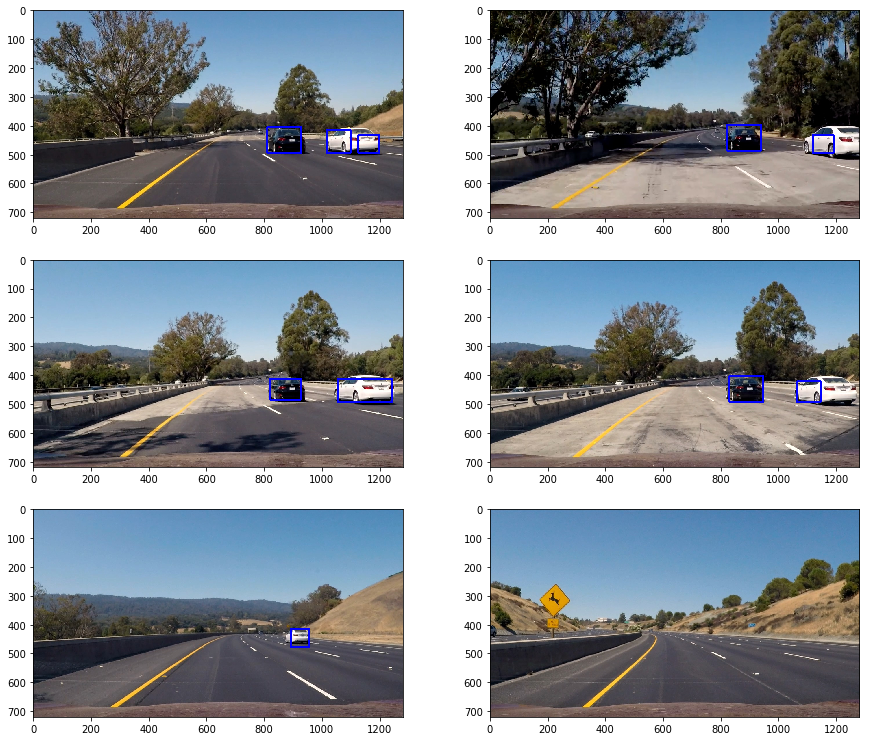

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # boxes have form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

def drawCarsWithLabels(img, boxes, threshHold = 4):
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshHold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
boxed_on_test = list(map(lambda img: drawCarsWithLabels(img, findCarWindows(img, svc, scaler)), test_images))

showImages(boxed_on_test)

/Users/dfrenk/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


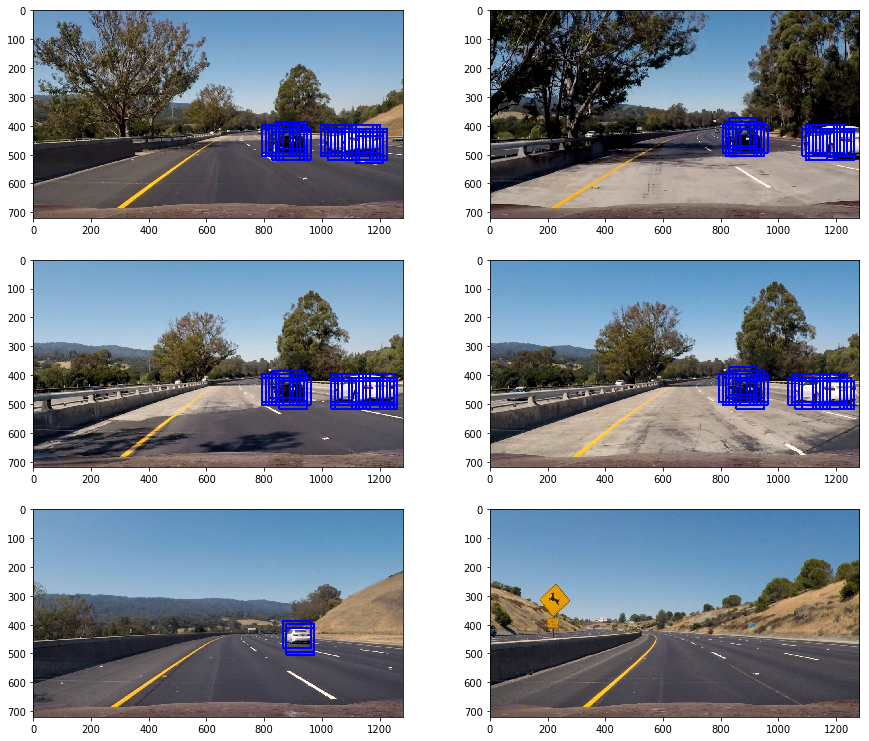

In [14]:
# ** Hog sub-sampling**
def findBoxes(img, clf, scaler, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):
    cspace = hog_parameters['cspace']
    orient = hog_parameters['orient']
    pix_per_cell = hog_parameters['pix_per_cell']
    cell_per_block = hog_parameters['cell_per_block']
    hog_channel = hog_parameters['hog_channel']
    size = hog_parameters['size']
    hist_bins = hog_parameters['hist_bins']
    hist_range = hog_parameters['hist_range']
    
    # convert to RGB / make a copy
    if cspace == 'HSV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

fast_boxes = list(map(lambda img: findBoxes(img, svc, scaler), test_images))

fast_on_test = list(map(lambda imgAndBox: drawCars(imgAndBox[0], imgAndBox[1]), zip(test_images, fast_boxes)))

showImages(fast_on_test)

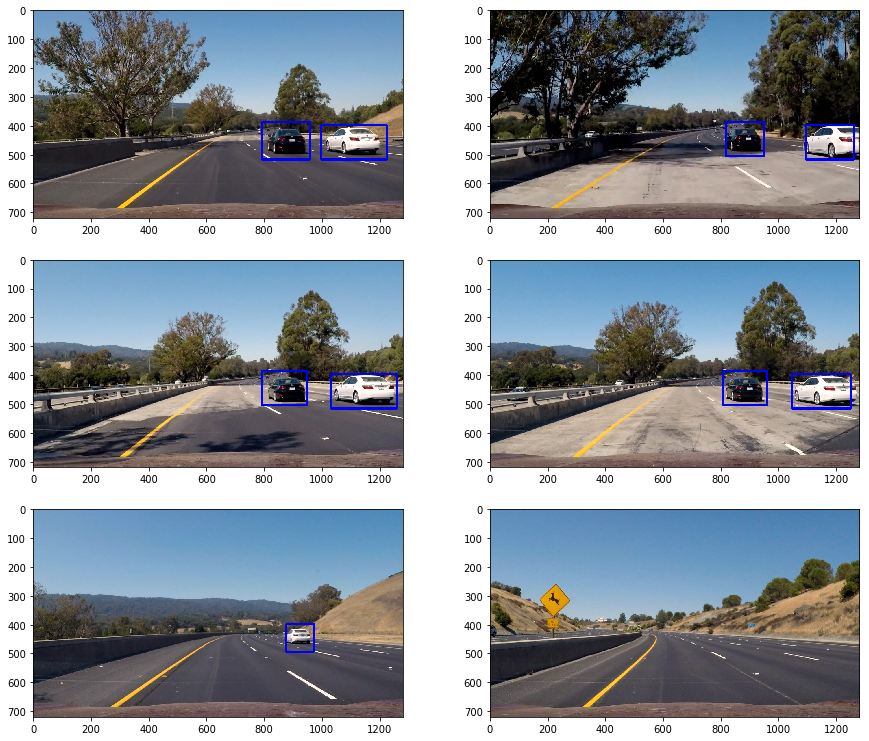

In [15]:
fast_on_test = list(map(lambda imgAndBox: drawCarsWithLabels(imgAndBox[0], imgAndBox[1], threshHold=1), zip(test_images, fast_boxes)))

showImages(fast_on_test)

**Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)**

The video is [here](./video_output/project_video.mp4)

In [18]:
from moviepy.editor import VideoFileClip
from functools import reduce

class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    
    history = HeatHistory()
    
    def pipeline(img):
        boxes = findBoxes(img, svc, scaler)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('./videos/project_video.mp4', './output_video/project_video.mp4', threshhold=2)

[MoviePy] >>>> Building video ./output_video/project_video.mp4
[MoviePy] Writing video ./output_video/project_video.mp4


100%|█████████▉| 1260/1261 [26:47<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_video.mp4 



# Discussion

**Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?**

Having implemented object detection with YOLO before, I found this pipeline much more difficult to implement (and my results were much less impressive). In particular, all the tunable hyperparameters combined with the relatively slow feedback loop (running the pipeline on test images often wasn't enough to give a good sense of how the pipeline would perform on the video) it felt like making progress was slow. In hindsight, I should have clipped the video to 5-10 seconds as a proxy for the final video, which would have sped up my feedback loop a lot (on my machine it typically took 25 mins to process the whole video, which I had to do 10+ times).

In an attempt to research optimization techniques, I found an old book from the 70s on computer vision, which was fascinating. In that book, they were trying to create scale invariant object templates for various common objects using HOG and other similar techniques (including hough transforms like we learned about in a previous lesson). I didn't find anything applicable to my pipeline, but it was an interesting read nonetheless.

One concern I have with the pipeline are its inability to distinguish multiple vehicles that are close to each other (because the bounding boxes are adjacent, so they end up getting combined by heatmap thresholding. I'm also not confident that it would generalize well to different weather and lighting conditions.